# Data exploration and cleaning

In [117]:
import numpy as np
import pandas as pd
import seaborn
import os

from matplotlib import pyplot as plt
from numpy import log1p


## Import data

### for jupter Notebook

In [118]:
# Ensure the file exists in the current directory or provide the correct path
print("Current Working Directory:", os.getcwd())
file_path = 'data/charting-m-points.csv' 

data = pd.read_csv(file_path, encoding='latin1')
	
print(data.columns)

Current Working Directory: c:\Users\gushi\LTU\TennisStrokePrediction


C:\Users\gushi\AppData\Local\Temp\ipykernel_17504\2372044445.py:5: DtypeWarning: Columns (7,12,24,25,26,31,32,33,34,35,45,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding='latin1')


Index(['match_id', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', 'Gm#', 'TbSet',
       'TB?', 'TBpt', 'Svr', 'Ret', 'Serving', '1st', '2nd', 'Notes',
       '1stNoLet', '2ndNoLet', '1stSV', '2ndSV', '1stNoSV', '2ndNoSV', '1stIn',
       '2ndIn', 'isRally1st', 'isRally2nd', 'Sv1', 'Sv2', 'Rally', 'isAce',
       'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble',
       'rallyNoSpec', 'rallyNoError', 'rallyNoDirection', 'rallyLen',
       'PtWinner', 'isSvrWinner', 'PtsAfter', 'GmW', 'Gm1.1', 'Gm2.1', 'SetW',
       'Set1.1', 'Set2.1', 'RevTB', 'TBrev', 'rallyCount'],
      dtype='object')


## Data cleaning

In [119]:
dropped_features = ["TbSet", "TBpt", "1st", "2nd", "Notes", "1stNoLet", "2ndNoLet", "1stSV", "2ndSV", "1stNoSV", "2ndNoSV", "1stIn", "2ndIn", "isRally1st", "isRally2nd", "Rally", "rallyNoSpec", "rallyNoDirection", "PtWinner", "isSvrWinner", "PtsAfter", 'GmW', 'Gm1.1', 'Gm2.1', 'SetW', 'Set1.1', 'Set2.1', "RevTB", "TBrev", "rallyCount"]

kept_features = ["Pt", "Set1", "Set2", "Gm1", "Gm2", "Pts", "Gm#", "TB?", "rallyLen"]

processing_features = [ "match_id", "Svr", "Ret", "Serving","Sv1", "Sv2","isAce", "isUnret", "isRallyWinner", "isForced", "isUnforced", "isDouble", "rallyNoError"]


data = data.drop(columns=dropped_features, errors='ignore')

# Split the data into two datasets
kept_features_data = data[kept_features].copy()
processing_features_data = data[processing_features].copy()

print("Kept Features Types:")
print(kept_features_data.dtypes)

print("\nProcessed Features Types:")
print(processing_features_data.dtypes)


Kept Features Types:
Pt            int64
Set1          int64
Set2          int64
Gm1           int64
Gm2         float64
Pts          object
Gm#          object
TB?         float64
rallyLen      int64
dtype: object

Processed Features Types:
match_id         object
Svr               int64
Ret              object
Serving          object
Sv1              object
Sv2              object
isAce              bool
isUnret          object
isRallyWinner    object
isForced         object
isUnforced       object
isDouble         object
rallyNoError     object
dtype: object


In [120]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
match_id              0
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   1
Pts                   0
Gm#                   1
TB?                  75
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205088
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
rallyLen              0
dtype: int64


# Process deduced features and compount features

In [121]:
def filter_data_by_player(data, target_player):
    """
    Filters the data for rows where the target player is playing.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Filtered dataset containing only rows where the target player is playing.
    """
    # Select "match_id" where target player is playing
    selected_match_ids = data.loc[data['Serving'] == target_player, 'match_id'].unique()

    # Filter rows in data where "match_id" is in the selected match_ids
    filtered_data = data[data['match_id'].isin(selected_match_ids)]
    
    return filtered_data

#In processing_data create "Svr" : 1 if the target player is serving, 0 if the target player is receiving
def create_svr_column(data, target_player): 
    """
    Creates a new column "Svr" in the dataset indicating if the target player is serving.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Updated dataset with the new "Svr" column.
    """
    data['Svr'] = np.where(data['Serving'] == target_player, 1, 0)
    return data

In [122]:
# define shot types to be mapped for our unforced error and winners array
shot_types = [
    'f', 'b',  # groundstrokes
    'r', 's',  # slices
    'v', 'z',  # volleys
    'o', 'p',  # overheads
    'u', 'y',  # drop shots
    'l', 'm',  # lobs
    'h', 'i',  # half-volleys
    'j', 'k',  # swinging volleys
]

# generate combinations with directions 1, 2, 3
shot_vocab = {f"{shot}{n}": idx for idx, (shot, n) in enumerate(
    (s, i) for s in shot_types for i in [1, 2, 3]
)}



In [123]:
def process_rally_data(df, shot_vocab):
    """
    Processes rally data into 3-shot sequences with serve context and a 48-class label array.

    Parameters:
        df (pd.DataFrame): Dataframe containing at least these columns:
            'Sv1', 'Sv2', 'rallyNoSpec', 'isAce', 'isUnret', 'isRallyWinner',
            'isForced', 'isUnforced', 'isDouble', 'rallyNoError'
        shot_vocab (dict): Mapping of shot codes (e.g., 'f1', 'b2') to indices (0-47)

    Returns:
        pd.DataFrame: New dataframe with columns ['shot1', 'shot2', 'shot3', 'label_array']
    """
    sequence_data = []

    for _, row in df.iterrows():
        rally_tokens=[]
        isServe = row['Svr'] == 1
        rally = row['rallyNoError']

        if (pd.isna(rally) or len(rally)<2):
            continue

        if (len(rally)==2):
            rally_tokens = [rally]
        else:
            rally_tokens.append(rally[:3])    # return is 3 characters instead of 2
            rally_tokens.extend([rally[i:i+2] for i in range(3, len(rally)-1, 2)])

        # serve logic
        if not pd.isna(row['Sv1']):
            if not pd.isna(row['Sv2']):  # second serve used
                full_rally = [row['Sv1'], row['Sv2']] + rally_tokens
            else:  # first serve only
                full_rally = ['0', row['Sv1']] + rally_tokens
        else:
            continue  # skip if no valid serve found

        # Create 48-dim label array
        winner_array = np.zeros(48)
        unforced_array = np.zeros(48)

        if len(rally_tokens) > 0:
            final_shot = rally_tokens[-1]
            idx = shot_vocab.get(final_shot, None)

            if idx is not None:
                if row['isRallyWinner']:
                    winner_array[idx] += 1  # winner
                elif row['isUnforced']:
                    unforced_array[idx] += 1  # unforced error

        # Generate 3-shot sequences
        if (isServe):
            i = 1
            while i + 2 < len(full_rally):
                sequence_data.append({
                    'shot1': full_rally[i],
                    'shot2': full_rally[i + 1],
                    'shot3': full_rally[i + 2],
                    'winner_array': winner_array.copy(),
                    'unforced_array': unforced_array.copy(),
                })
                i += 2
        else:
            i = 0
            while i + 2 < len(full_rally):
                sequence_data.append({
                    'shot1': full_rally[i],
                    'shot2': full_rally[i+1],
                    'shot3': full_rally[i+2],
                    'winner_array': winner_array.copy(),
                    'unforced_array': unforced_array.copy(),
                })
                i += 2


    return pd.DataFrame(sequence_data)

### Acutual processing

In [124]:
processing_data = data.copy()
target_player = "RF"

# Test the filter_data_by_player function
processing_data = filter_data_by_player(processing_data, target_player)

# Print the number of unique match IDs selected
num_unique_matches = len(processing_data['match_id'].unique())
print(f"Number of Unique Matches Found: {num_unique_matches}")

# Print the number of rows selected
num_rows_selected = processing_data.shape[0]
print(f"Number of Rows Selected: {num_rows_selected}")

# Calculate and print the sum of rally lengths for all rows
if 'rallyLen' in processing_data.columns:
    rally_len_sum = processing_data['rallyLen'].sum()
    print(f"Sum of Rally Lengths: {rally_len_sum}")
else:
    print("Column 'rallyLen' not found in the dataset.")

# Test the create_svr_column function
processing_data = create_svr_column(processing_data, target_player)

Number of Unique Matches Found: 322
Number of Rows Selected: 55713
Sum of Rally Lengths: 200252


In [125]:
print(processing_data["rallyNoError"].head(5))

6980            f27f3
6981               s2
6982               f1
6983    b38f3b1f1f3s2
6984              NaN
Name: rallyNoError, dtype: object


In [126]:
sequence_data = process_rally_data(processing_data,shot_vocab=shot_vocab)
sequence_data.head()

,shot1,shot2,shot3,winner_array,unforced_array
0,4,f27,f3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5,b38,f3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,f3,b1,f1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,f1,f3,s2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,6,b27,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [133]:
processing_data = pd.concat([processing_data,sequence_data], ignore_index=True)
processed_data = processing_data.drop(columns=processing_features, errors='ignore')
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247461 entries, 0 to 247460
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Pt              55713 non-null   float64
 1   Set1            55713 non-null   float64
 2   Set2            55713 non-null   float64
 3   Gm1             55713 non-null   float64
 4   Gm2             55713 non-null   float64
 5   Pts             55713 non-null   object 
 6   Gm#             55713 non-null   object 
 7   TB?             55713 non-null   float64
 8   rallyLen        55713 non-null   float64
 9   shot1           191748 non-null  object 
 10  shot2           191748 non-null  object 
 11  shot3           191748 non-null  object 
 12  winner_array    191748 non-null  object 
 13  unforced_array  191748 non-null  object 
dtypes: float64(7), object(7)
memory usage: 26.4+ MB


In [129]:
processed_data['TB?'].fillna(0, inplace=True)

# Remove rows where 'Gm2' or 'Gm#' have missing values
processed_data.dropna(subset=['Gm2', 'Gm#'], inplace=True)

print("\nMissing values after handleing:")
print(processed_data.isnull().sum())


Missing values after handleing:
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   0
Pts                   0
Gm#                   0
TB?                   0
rallyLen              0
shot1             55713
shot2             55713
shot3             55713
winner_array      55713
unforced_array    55713
dtype: int64


In [130]:
# Backup dataset
processed_data.to_csv('data/processed_features.csv', index=False)

### quality check

In [131]:
#encode categorical variables

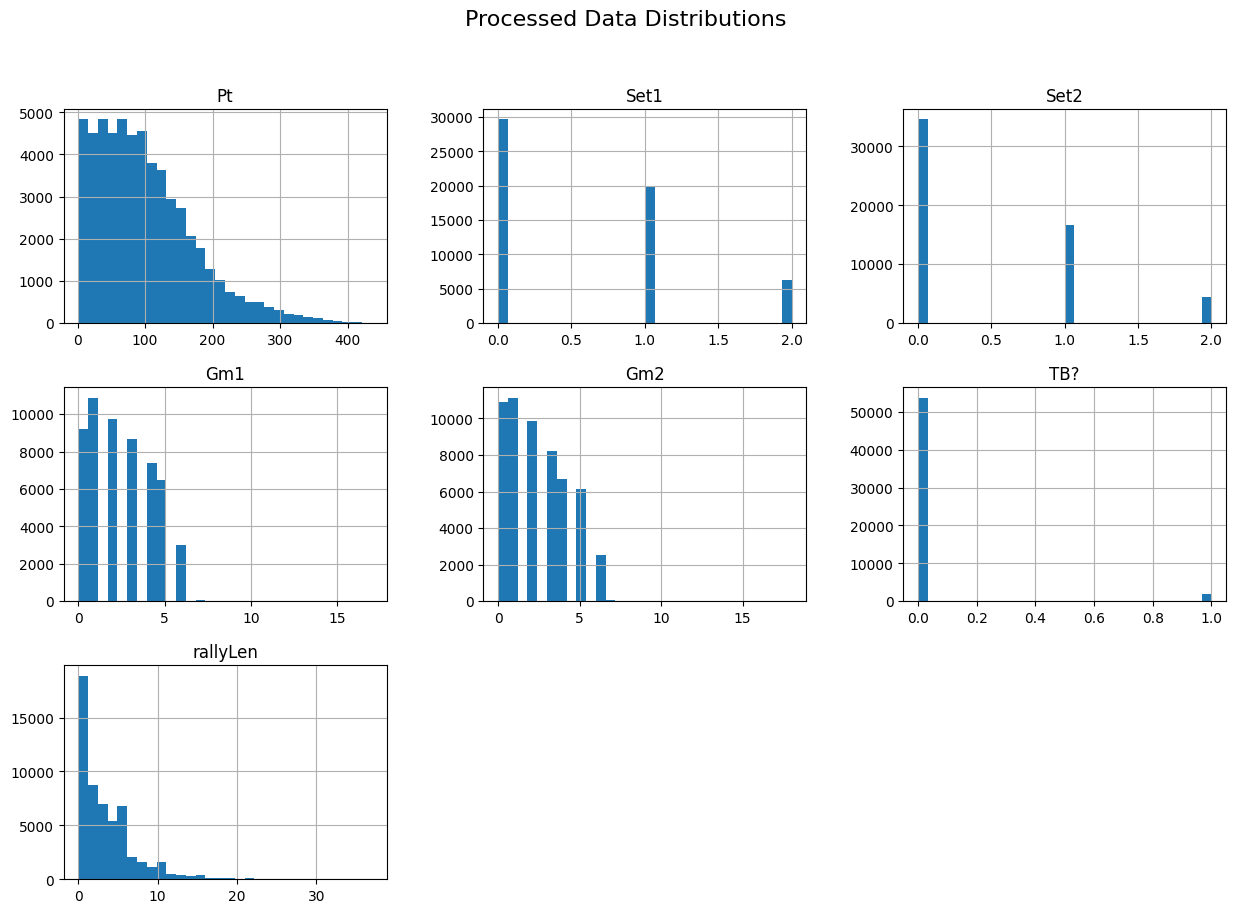

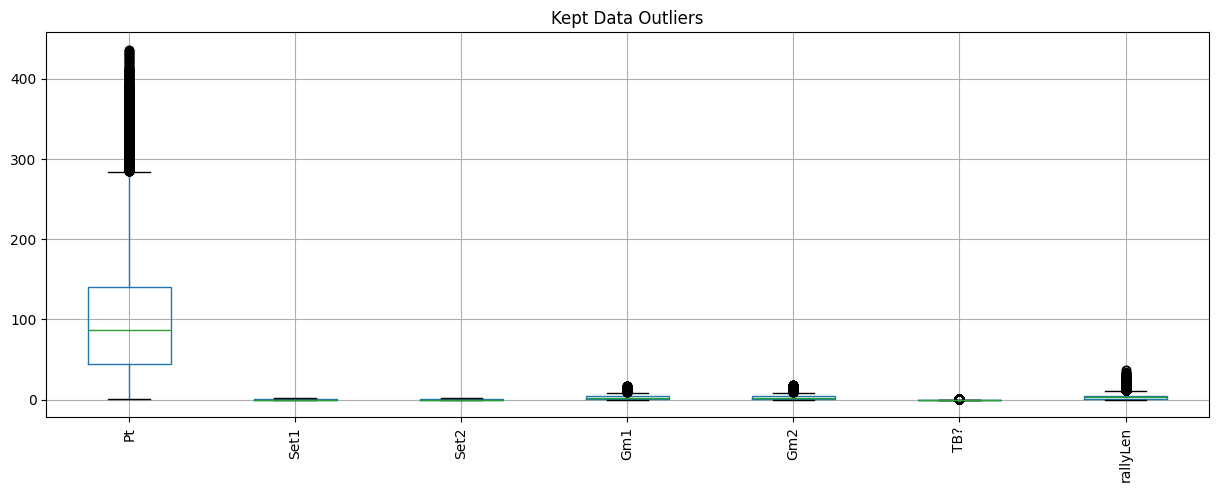


Processed Data Summary Statistics:
                 Pt          Set1          Set2           Gm1           Gm2  \
count  55713.000000  55713.000000  55713.000000  55713.000000  55713.000000   
mean      99.815339      0.580672      0.460467      2.501283      2.350044   
std       72.378972      0.685003      0.640442      1.903350      1.907012   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%       44.000000      0.000000      0.000000      1.000000      1.000000   
50%       87.000000      0.000000      0.000000      2.000000      2.000000   
75%      140.000000      1.000000      1.000000      4.000000      4.000000   
max      436.000000      2.000000      2.000000     17.000000     18.000000   

                TB?      rallyLen  
count  55713.000000  55713.000000  
mean       0.034839      3.594350  
std        0.183374      3.678951  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%        0.000000      3.000000  


In [132]:
# Visualize distributions to identify skewness
processed_data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Processed Data Distributions", fontsize=16)
plt.show()

# Visualize outliers using boxplots
plt.figure(figsize=(15, 5))
processed_data.boxplot()
plt.title("Kept Data Outliers")
plt.xticks(rotation=90)
plt.show()

print("\nProcessed Data Summary Statistics:")
print(processed_data.describe())